In [1]:
import numpy as np 
from PIL import Image 
import os 
import cv2 
import math 
import matplotlib.pyplot as plt 
from scipy.spatial.transform import Rotation as R 

In [2]:
def marker_reprojection(image, pred, marker_image, marker_corners_2d, marker_corners_3d, rvec, tvec, camera_matrix, dist_coeffs, alpha):
    # Load the image and marker image 
    image = np.array(image) 
    if image.shape[2] == 4: 
        image = cv2.cvtColor(image, cv2.COLOR_RGBA2RGB) 
    marker_image = np.array(marker_image) 

    # Project the 3D model points of the marker to the image
    rvec = np.array(rvec, dtype=np.float32) 
    tvec = np.array(tvec, dtype=np.float32) 
    image_points, _ = cv2.projectPoints(marker_corners_3d, rvec, tvec, camera_matrix, dist_coeffs)

    # Convert the image points to integer
    image_points = np.round(image_points).astype(int)

    # Draw the marker on the image 
    reprojected_marker_mask = cv2.fillPoly(image*0, [image_points], (255, 255, 255)) 
    
    image = cv2.addWeighted(image, alpha, pred, 1 - alpha, 0) 

    marker_image_corners = np.array([
        [0, 0],
        [marker_image.shape[1], 0],
        [marker_image.shape[1], marker_image.shape[0]],
        [0, marker_image.shape[0]] 
    ], dtype=np.float32)

    image_points = np.array(image_points).reshape(-1, 2).astype(np.float32) # NOTE: is this needed? 
    M = cv2.getPerspectiveTransform(marker_image_corners, image_points) 

    # define overlay to be each pixel of the marker image transformed using H 
    reprojected_marker_image = cv2.warpPerspective(marker_image, M, (image.shape[1], image.shape[0])) 
    blended_image = cv2.addWeighted(image, 1-alpha, reprojected_marker_image, alpha, 0) 

    return reprojected_marker_image, reprojected_marker_mask, blended_image    

def image_overlap_error(img, img_mask, pred, pred_mask): 

    filter = "mean_threshold" # "min_max", "local", "mean_threshold"

    img = np.array(img) 
    if img.shape[2] == 4:   
        img = cv2.cvtColor(img, cv2.COLOR_RGBA2RGB) 
    img_mask = np.array(img_mask) 
    pred = np.array(pred) 
    pred = cv2.cvtColor(pred, cv2.COLOR_BGR2GRAY) # convert pred to grayscale 
    pred_mask = np.array(pred_mask) 

    img_grey = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)    

    binary_mask = img_mask.copy() 
    binary_mask[binary_mask > 0] = 255 

    masked_pixels = img[img_mask == 255]

    if filter == "min_max": 
        # Find the minimum and maximum pixel values in the masked region
        min_pixel_value = np.min(masked_pixels)
        max_pixel_value = np.max(masked_pixels)

        # normalize img using range of img_mask 
        img_dot_mask = cv2.bitwise_and(img, img_mask)     
        img_filtered = cv2.normalize(img_dot_mask, None, min_pixel_value, max_pixel_value, cv2.NORM_MINMAX) 
    elif filter == "local":
        # TODO: localized regions normalization 
        pass 
    elif filter == "mean_threshold": 
        img_masked_mean = masked_pixels.mean() 
        # threshold img using img_masked_mean as threshold 
        _, img_filtered = cv2.threshold(img_grey, img_masked_mean, 255, cv2.THRESH_BINARY) 
        img_filtered = np.array(img_filtered)

    intersection = cv2.bitwise_and(img_mask, pred_mask) 

    # for each pixel of intersection, compute error between img and pred 
    error = 0 
    for i in range(intersection.shape[0]):
        for j in range(intersection.shape[1]):
            if intersection[i][j][0] == 255:

                # error += np.linalg.norm(img_filtered[i][j] - pred[i][j]) 
                
                if img_filtered[i][j] == pred[i][j]: 
                    error -= 1 
                
                # error += np.sum((img_grey[i][j] - pred[i][j]) ** 2)
    return error 


def xyzabc_to_rvectvec(xyzabc): 
    tvec = xyzabc[:3] 
    rot = R.from_euler("xyz",xyzabc[3:],degrees=True).as_matrix()
    rvec = cv2.Rodrigues(rot)[0] 
    return rvec, tvec 

def rvectvec_to_xyzabc(rvec, tvec): 
    rot = cv2.Rodrigues(rvec)[0] 
    tvec = tvec.reshape(3)
    xyzabc = np.concatenate((tvec, R.from_matrix(rot).as_euler("xyz",degrees=True))) 
    return xyzabc 

def xyzabc_to_tf(xyzabc): 
    tvec = xyzabc[:3] 
    rot = R.from_euler("xyz",xyzabc[3:],degrees=True).as_matrix()
    tf = np.eye(4) 
    tf[:3,:3] = rot 
    tf[:3,3] = tvec 
    return tf

def tf_to_xyzabc(tf): 
    rot = tf[:3,:3] 
    tvec = tf[:3,3] 
    xyzabc = np.concatenate((tvec, R.from_matrix(rot).as_euler("xyz",degrees=True))) 
    return xyzabc 

def reproject_marker(marker_image, xyzabc, camera_matrix=None, dist_coeffs=None, pred_np=None, pred_mask=None):
    # FIXME: make this function work 
    if camera_matrix is None: 
        camera_matrix = np.array([[1000, 0, 320], [0, 1000, 240], [0, 0, 1]], dtype=np.float32) 
    if dist_coeffs is None:
        dist_coeffs = np.zeros((5, 1), dtype=np.float32)
    if pred_np is None: 
        pred_np = np.zeros((480, 640, 3), dtype=np.uint8) 
    if pred_mask is None:
        pred_mask = np.zeros((480, 640, 3), dtype=np.uint8) 

    if marker_corners_2d is None: 
        marker_corners_2d = np.array([[0, 0], [marker_image.shape[1], 0], [marker_image.shape[1], marker_image.shape[0]], [0, marker_image.shape[0]]], dtype=np.float32)

    if marker_corners_3d is None: 
        marker_corners_3d = np.array([[0, 0, 0], [marker_image.shape[1], 0, 0], [marker_image.shape[1], marker_image.shape[0], 0], [0, marker_image.shape[0], 0]], dtype=np.float32) 

    rotation_vector, translation_vector = xyzabc_to_rvectvec(xyzabc) 
    # Load the marker image 
    reprojected_marker_image, reprojected_marker_mask, blended_image = marker_reprojection(marker_image, pred_np, marker_image, marker_corners_2d, marker_corners_3d, rotation_vector, translation_vector, camera_matrix, dist_coeffs, 0.8)
    return reprojected_marker_image 

In [3]:
# define marker corners in marker frame 
marker_img_path = "../synthetic_data_generation/assets/tags/4x4_1000-31.png" 
marker_img = cv2.imread(marker_img_path) 
marker_side_length = 0.100 # measured with calipers 
marker_corners_3d = [
    [+marker_side_length/2,+marker_side_length/2,0], 
    [-marker_side_length/2,+marker_side_length/2,0], 
    [-marker_side_length/2,-marker_side_length/2,0], 
    [+marker_side_length/2,-marker_side_length/2,0], 
] 
marker_corners_3d = np.array(marker_corners_3d, dtype=np.float32)

camera = "isaac" # isaac, iphone, ipad 

if camera == "isaac": 
    # assume isaac sim default 
    width = 640 
    height = 480 
    focal_length = 24.0 
    horiz_aperture = 20.955
    # Pixels are square so we can do:
    vert_aperture = height/width * horiz_aperture
    fov = 2 * math.atan(horiz_aperture / (2 * focal_length))
    # compute focal point and center
    fx = width * focal_length / horiz_aperture
    fy = height * focal_length / vert_aperture
    cx = width / 2
    cy = height /2 
else: 
    if camera == "iphone": 
        # assume iphone camera default 
        fx = 2940 / 10000
    if camera == "ipad": 
        # assume ipad camera default 
        fx = 3580  
    fxy = 2940 / 10000 # for iphone camera (approx)
    fxy = 3580 # for ipad camera (approx)
    fx = fxy 
    fy = fxy 
    cx = 640/2  
    cy = 480/2  

camera_matrix = np.array([
    [fx,0,cx],
    [0,fy,cy],
    [0,0,1]
])
dist_coeffs = np.zeros((5, 1), dtype=np.float32)
img = np.zeros((480,640,3), dtype=np.uint8) 
pred_np = np.zeros((480,640,3), dtype=np.uint8) 
marker_corners_2d = None 

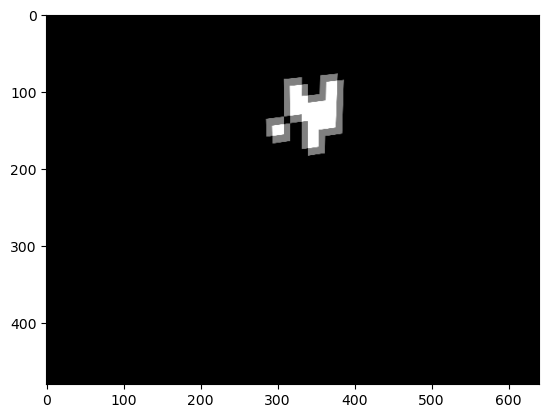

In [4]:
# define random translation and rotation 
xyzabc = np.array(
    [
        np.random.uniform(-0.1, 0.1), # x
        np.random.uniform(-0.1, 0.1), # y
        np.random.uniform(0.5, 0.5), # z
        np.random.uniform(-45, 45), # roll
        np.random.uniform(-45, 45), # pitch
        np.random.uniform(-180, 180)  # yaw
    ]
)
true_rotation_vector, true_translation_vector = xyzabc_to_rvectvec(xyzabc) 

# output image of marker with pose rvec, tvec 
true_reprojected_marker_image, true_reprojected_marker_mask, blended_image = marker_reprojection(img, pred_np, marker_img, marker_corners_2d, marker_corners_3d, true_rotation_vector, true_translation_vector, camera_matrix, dist_coeffs, 0.8)
# plt.imshow(true_reprojected_marker_image)
# plt.show() 

error = np.array(
    [
        np.random.uniform(-0.01, 0.01), # x
        np.random.uniform(-0.01, 0.01), # y
        np.random.uniform(-0.01, 0.01), # z 
        np.random.uniform(-1, 1), # roll
        np.random.uniform(-1, 1), # pitch
        np.random.uniform(-1, 1)  # yaw
    ]
)

# add error to translation and rotation 
xyzabc_noisy = xyzabc + error 
noisy_rotation_vector, noisy_translation_vector = xyzabc_to_rvectvec(xyzabc_noisy) 
# output image of marker with pose rvec, tvec 
noisy_reprojected_marker_image, noisy_reprojected_marker_mask, noisy_blended_image = marker_reprojection(img, pred_np, marker_img, marker_corners_2d, marker_corners_3d, noisy_rotation_vector, noisy_translation_vector, camera_matrix, dist_coeffs, 0.8)
# plt.imshow(noisy_reprojected_marker_image)
# plt.show() 

# combine true_reprojected_marker_image and noisy_reprojected_marker_image 
blended_image = cv2.addWeighted(true_reprojected_marker_image, 0.5, noisy_reprojected_marker_image, 0.5, 0)
plt.imshow(blended_image)
plt.show() 

Overlap error: -13642.0, Pose error: [-0.00353922 -0.00460382 -0.00605197 -0.17282541 -0.37445039 -0.66606984]
Overlap error: -13642.0, Pose error: [-0.00353922 -0.00460382 -0.00605197 -0.17282541 -0.37445039 -0.66606984]
Overlap error: -13642.0, Pose error: [-0.00363753 -0.00458755 -0.00607504 -0.17282541 -0.37445038 -0.66606984]
Overlap error: -13521.0, Pose error: [-0.00373515 -0.00457127 -0.00609786 -0.17282542 -0.37445037 -0.66606983]
Overlap error: -13394.0, Pose error: [-0.00383124 -0.00455515 -0.00612024 -0.17282542 -0.37445037 -0.66606983]
Overlap error: -13394.0, Pose error: [-0.00392577 -0.00453919 -0.00614218 -0.17282543 -0.37445036 -0.66606982]
Overlap error: -13303.0, Pose error: [-0.00401969 -0.00452323 -0.0061639  -0.17282543 -0.37445035 -0.66606982]
Overlap error: -13278.0, Pose error: [-0.00411235 -0.00450738 -0.00618525 -0.17282544 -0.37445035 -0.66606981]
Overlap error: -13278.0, Pose error: [-0.00420425 -0.00449157 -0.00620636 -0.17282544 -0.37445034 -0.66606981]
O

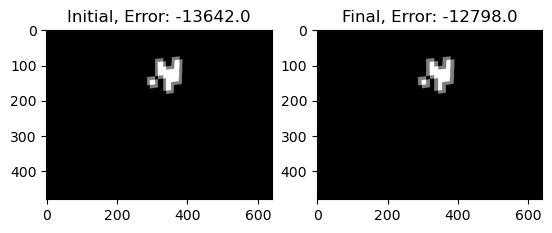

Final reprojection error: -12798.0


Text(0.5, 1.0, 'Reprojection Error vs Iteration')

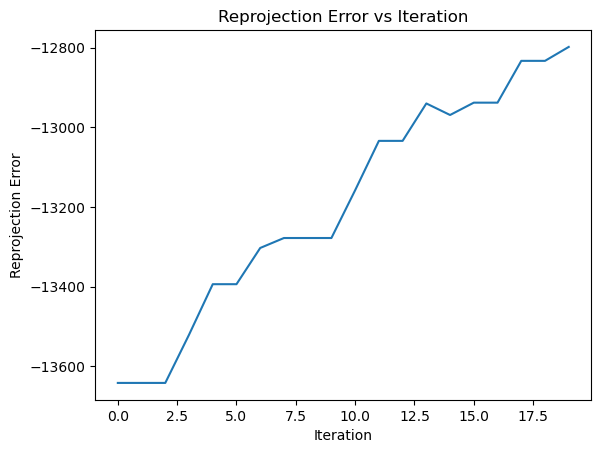

In [ ]:
true_pose = xyzabc_to_tf(xyzabc) 
true_pose_inv = np.linalg.inv(true_pose)

opt_var = "pose" 
N = 20        
eps = 1e-16 
N_grad_sample = 10 
errors = np.zeros(N) 
alpha = np.array([1e-9,1e-9,1e-9,1e-10,1e-10,1e-10]) * .1   
solutions = np.zeros((N, 6)) 
solutions[0] = rvectvec_to_xyzabc(noisy_rotation_vector, noisy_translation_vector) 
grads = np.zeros((N, 6))
for i in range(N): 

    # update step 
    if i == 0: 
        # grad_noise = ((2*np.random.rand(solutions.shape[1]))-1)*10.0   
        grad_noise = ((2*np.random.rand(solutions.shape[1]))-1)*np.array([0.010,0.010,0.010,1,1,1]) 
        grad = grad_noise  

        # show initial image 
        rvec, tvec = xyzabc_to_rvectvec(solutions[i]) 
        reprojected_marker_image, reprojected_marker_mask, blended_image = marker_reprojection(img, pred_np, marker_img, marker_corners_2d, marker_corners_3d, rvec, tvec, camera_matrix, dist_coeffs, 0.8)                    
        # blended_image = Image.fromarray(blended_image) 
        # blended_image.show()
    else:
        if i == 1: 
            grad_noise = ((2*np.random.rand(solutions.shape[1]))-1)*np.array([0.010,0.010,0.010,1,1,1]) 
            grad = grad_noise  
        else: 
            grad = (errors[i] - errors[i-1]) / (solutions[i] - solutions[i-1] + eps)   

            solution_center = solutions[i-1] 
            error_center = errors[i-1] 
            errors_grad_sample = np.zeros(N_grad_sample) 
            grad_samples = np.zeros((N_grad_sample, 6)) 
            for i in range(N_grad_sample): 
                noise = np.array([
                    np.random.uniform(-0.01, 0.01), # x
                    np.random.uniform(-0.01, 0.01), # y
                    np.random.uniform(-0.01, 0.01), # z
                    np.random.uniform(-1, 1), # roll
                    np.random.uniform(-1, 1), # pitch
                    np.random.uniform(-1, 1)  # yaw
                ])
                solution_perturb = solution_center + noise 
                rvec, tvec = xyzabc_to_rvectvec(solution_perturb) 
                reprojected_marker_image, reprojected_marker_mask, blended_image = marker_reprojection(img, pred_np, marker_img, marker_corners_2d, marker_corners_3d, rvec, tvec, camera_matrix, dist_coeffs, 0.8)                    
                errors_grad_sample[i] = image_overlap_error(true_reprojected_marker_image, true_reprojected_marker_mask, reprojected_marker_image, reprojected_marker_mask) 

                grad_samples[i] = (errors_grad_sample[i] - error_center) / noise  
            grad = grad_samples.mean(axis=0)

        # solutions[i] = solutions[i-1] - alpha*grad 
        # FIXME: getting very high gradients due to error changing when some pixel dimensions have near-zero change 
        # TODO: if gradient is too large or too small, then randomly perturb pixels and recompute solution 
        if np.max(np.abs(grad)) > 1_000_000_000: # gradient clipping 
            print(f"Huge gradient! Gradient: {grad}") 
            grad_noise = ((2*np.random.rand(solutions.shape[1]))-1)*100.0 
            grad = grad_noise   
        elif np.max(np.abs(grad)) < 1e-16: # stop if gradient is too small
            print(f"Tiny gradient! Gradient: {grad}")  
            grad_noise = ((2*np.random.rand(solutions.shape[1]))-1)*np.array([0.010,0.010,0.010,10,10,10]) * 100  
            grad = grad_noise 
        solutions[i] = solutions[i-1] - alpha*grad 

    # take pose and reproject marker 
    rvec, tvec = xyzabc_to_rvectvec(solutions[i]) 
    reprojected_marker_image, reprojected_marker_mask, blended_image = marker_reprojection(img, pred_np, marker_img, marker_corners_2d, marker_corners_3d, rvec, tvec, camera_matrix, dist_coeffs, 0.8)                    
    # print pose error 

    # compute error between reprojected marker and pred 
    errors[i] = image_overlap_error(true_reprojected_marker_image, true_reprojected_marker_mask, reprojected_marker_image, reprojected_marker_mask) 

    if i % 1 == 0: 
        tf_guess = xyzabc_to_tf(solutions[i])
        tf_error = true_pose_inv @ tf_guess 
        
        pose_error = tf_to_xyzabc(tf_error) 
        print(f"Overlap error: {errors[i]}, Pose error: {pose_error}") 

# compare blended images 
blended_image_initial = cv2.addWeighted(true_reprojected_marker_image, 0.5, noisy_reprojected_marker_image, 0.5, 0)
blended_image_final = cv2.addWeighted(true_reprojected_marker_image, 0.5, reprojected_marker_image, 0.5, 0)
# show blended images side by side 
plt.subplot(1, 2, 1)
plt.imshow(blended_image_initial)
plt.title(f"Initial, Error: {errors[0]}")
plt.subplot(1, 2, 2)
plt.imshow(blended_image_final)
plt.title(f"Final, Error: {errors[-1]}")
plt.show()

# print(min_reprojection_error)

print(f"Final reprojection error: {errors[-1]}")  

# plot reprojection error vs iteration 
plt.plot(errors) 
plt.xlabel("Iteration") 
plt.ylabel("Reprojection Error") 
plt.title("Reprojection Error vs Iteration")  


In [ ]:
N_grad_sample = 10 
solution_center = solutions[-1] 
error_center = image_overlap_error(true_reprojected_marker_image, true_reprojected_marker_mask, reprojected_marker_image, reprojected_marker_mask) 
errors_grad_sample = np.zeros(N_grad_sample) 
grad_samples = np.zeros((N_grad_sample, 6)) 
solutions_perturb = np.zeros((N_grad_sample, 6)) 
for i in range(N_grad_sample): 
    noise = np.array([
        np.random.uniform(-0.01, 0.01), # x
        np.random.uniform(-0.01, 0.01), # y
        np.random.uniform(-0.01, 0.01), # z
        np.random.uniform(-1, 1), # roll
        np.random.uniform(-1, 1), # pitch
        np.random.uniform(-1, 1)  # yaw
    ]) * 0.01
    solutions_perturb[i,:] = solution_center + noise 
    rvec, tvec = xyzabc_to_rvectvec(solutions_perturb[i,:]) 
    reprojected_marker_image, reprojected_marker_mask, blended_image = marker_reprojection(img, pred_np, marker_img, marker_corners_2d, marker_corners_3d, rvec, tvec, camera_matrix, dist_coeffs, 0.8)                    
    errors_grad_sample[i] = image_overlap_error(true_reprojected_marker_image, true_reprojected_marker_mask, reprojected_marker_image, reprojected_marker_mask) 

    grad_samples[i] = (errors_grad_sample[i] - error_center) / noise  
    print(f"{grad_samples[i]}")

mean_grad = grad_samples.mean(axis=0)
std_grad = grad_samples.std(axis=0) 

print(f"Mean gradient: {mean_grad}")
print(f"Std gradient: {std_grad}")


print(solutions_perturb)
print(errors_grad_sample) 


[ 1304039.60947344  3080999.1894805  -1525948.94170194   -54518.03624862
   -23402.89605119    19615.94189779]
[4335866.79081372 1982596.94513895 1945982.98164754  -68066.77619234
 -220091.36992531  934760.41917298]
[  328799.85898185 -2997849.21767172   634656.15424632   100034.83142461
     3401.21358419   -12347.90829031]
[-6.52475690e+07  9.27402383e+05  2.45298878e+06  9.67781635e+04
 -1.49427095e+04 -1.37680762e+04]
[ 1962225.25649005  2855993.19895995 -2334651.83971079    72413.64842268
   -26680.18196141   -62092.06636661]
[1394553.23798504 1066672.17583455 -903965.62839982   68027.3106369
    9715.8952421   -27108.48609868]
[ 2107815.68068713  2096413.7082485  -1263525.03620159    22069.51797974
    -8518.76810519   -24540.29678945]
[ 1181016.6511188  -2078210.14002767  1187119.73139446    23959.23043792
   -53299.78955991    20897.30194418]
[-3594134.17221008  1886369.92068973  1899684.45424996    32930.71006784
   113378.59110991   -19946.54283468]
[ 302867.37392848 -328896.